# Case #6
## Michael Catalano, Martin Garcia, Jeremy Otsap, Christian Nava

# Introduction

#### Taken from the abstract of the white paper "Searching for Exotic Particles in High-Energy Physics with Deep Learning", "collisions at high-energy particle colliders are a source of exotic particle discoveries. Finding these rare particles requires solving difficult signal-versus-background classification problems." The authors utilize a deep neural network approach to handle this classification task. From the results of the experiment, it is evident that deep learning approaches like neural networks can improve the power of collider searches for exotic particles, particularly how to classify either a signal versus background classes.

#### As we dig deeper into the methods used by the authors in 2014, its incredible how far neural networks have come. Improvements in libraries, new activation functions and optimizers, and economies of scale have helped pave the way for building competing neural networks at home without the need of multi-core cloud solutions. Standard practices used when the paper was published have changed; modifications to the methods used in the paper might show comperable or even better performance at a fraction of the computation cost.

#### The following analysis replicates the deep learning model from the architecture used in the 2014 white paper, discusses the assumptions used in the model, and proposes modifications where appropriate.

### Deep Neural Networks

#### In the paper, the authors build and compare multiple deep neural networks before selecting the best-performing model for use in their final classification tool. In its most simplistic form, a neural network consists of nodes which make up layers of a network. A simple one-layer neural network contains an input layer, hidden layer, and an output layer. All inputs are modified by a weight and summed (linear combination). Finally, an activation function controls the amplitude of the output. The network essentially "learns" the distribution function of the observed data, and iteratively improves its predictive power by batching through training samples.

#### The structure of a neural network dictates the depth and complexity, as "deep" neural networks often have multiple layers. Figure 1 below shows an example of a one-layer neural network.

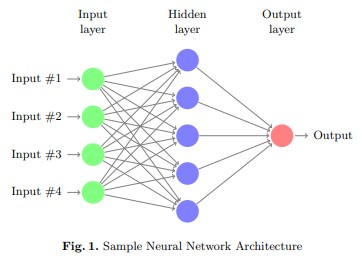

### Hyperparameters within Neural Network Configurations

#### * Learning rate: an important hyperparameter used in the training of neural networks, and is typically between 0 and 1. "The learning rate controls how quickly the model is adapted to the problem. Smaller learning rates require more training epochs given the smaller changes made to the weights after each update, whereas larger learning rates result in rapid changes and require fewer training epochs." So what does this mean, exactly? The learning rate controls the stability of a model; set it too small and the training process could get stuck and our model might not learn. Setting the value too large may result in learning a sub-optimal set of weights too quickly and overfitting might occur.

#### * Weight decay coefficient: A parameter used to prevent our model from getting too complex; prevent overfitting by multiplying the sum of squares with a small, aribitrary value. A more technical defintion: "Weight decay specifies regularization in the neural network. During training, a regularization term is added to the network's loss to compute the backpropagation gradient. The weight decay value determines how dominant this regularization term will be in the gradient computation."

#### * Activation function: Decides whether a neuron in the hidden layer should be activated based on the calculation of a weighted sum plus a bias term. The purpose of the activation function is to introduce non-linearity into the output of a neuron, else its a linear regression model. "The activation function does the non-linear transformation to the input making it capable to learn and perform more complex tasks." The choice of which activation function to use is dependent on the output of a problem (classification, probabilistic prediction, etc.), however there is no hard or fast rule.

#### * Batch size (aka mini-batches): When training a neural network, this is the number of samples that will be sent through the network at one time. Generally, the larger the batch size, the quicker the epochs run. There is a trade-off between batch size and computational resources on the machine one needs to be aware of.

#### * Epoch: A single pass of all data through the network. Set in the configuration of your model.


### Paper Methodology and Data

#### The authors select a five-layer neural network with 300 hidden units in each layer, a learning rate of 0.05, and a weight decay coefficient of 1 × 10−5. Going back to Figure 1, we only showed a single-layer network with five hidden units. You can imagine how large this structure would be to visualize with five layers and 300 units each!

#### Neural networks are subject to immense tuning, often governed by time and resources. One universally accepted notion is these networks require large training datasets. For example, the authors used 11 million simulated collision events for benchmarking, with 28 features. The authors split these features into low and high-levels per the amount of discrimination power, though hyper-parameter optimization was performed using the full set of HIGGS features (all 28).

#### The training set consists of 2.6 million examples and 100,000 validation examples. The following hyperparameters are used in training (from the paper):
* Weights were initialized from a normal distribution with zero mean and standard deviation 0.1 in the first layer, 0.001 in the output layer, and 0.05 all other hidden layers
* Hidden units all used the tanh activation function
* Gradient computations were made on mini-batches of size 100
* A momentum term increased linearly over the first 200 epochs from 0.9 to 0.99, at which point it remained constant
* The learning rate decayed by a factor of 1.0000002 every batch update until it reached a minimum of 10−6

##### Sources:
https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/#:~:text=The%20amount%20that%20the%20weights,range%20between%200.0%20and%201.0.
https://stats.stackexchange.com/questions/273189/what-is-the-weight-decay-loss#:~:text=Weight%20decay%20specifies%20regularization%20in,be%20in%20the%20gradient%20computation.
https://www.geeksforgeeks.org/activation-functions-neural-networks/

## 1. Replicate results from paper

In [1]:
import os
import logging
import logging.config
import numpy as np 
import pandas as pd
import tensorflow as tf
import pandas as pd 
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns

# Remove scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
# From https://arxiv.org/abs/1402.4735

#### Get working Directory

In [3]:
os.getcwd()

'C:\\Users\\Mike'

#### Get Data

In [4]:
# Downloads a file from a URL if it not already in the cache. Will save in .keraset/dataset folder
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

Contains 11,000,000 examples, each with 28 features, and a binary class label.

In [4]:
higgs = pd.read_csv('.keras/datasets/HIGGS.csv.gz',nrows = 250000, skiprows = 10)

Sample of 250,000 records from the first 2.5 million (skiprows of 10)

In [5]:
higgs.head()

,1.000000000000000000e+00,9.459739923477172852e-01,1.111244320869445801e+00,1.218337059020996094e+00,9.076390862464904785e-01,8.215369582176208496e-01,1.153243303298950195e+00,-3.654202818870544434e-01,-1.566054821014404297e+00,0.000000000000000000e+00,...,-4.510180354118347168e-01,6.365344673395156860e-02,3.101961374282836914e+00,8.290241360664367676e-01,9.806482791900634766e-01,9.943597912788391113e-01,9.082478284835815430e-01,7.758789062500000000e-01,7.833113670349121094e-01,7.251217961311340332e-01
0,0.00000,0.73936,-0.17829,0.82993,0.50454,-0.13022,0.96105,-0.35552,-1.71740,2.17308,...,0.77406,0.39882,3.10196,0.94454,1.02626,0.98220,0.54211,1.25098,0.83004,0.76131
1,1.00000,1.38410,0.11682,-1.17988,0.76291,-0.07978,1.01986,0.87732,1.27689,2.17308,...,0.84652,0.50481,3.10196,0.95932,0.80738,1.19181,1.22121,0.86114,0.92934,0.83830
2,1.00000,1.38355,0.88918,0.61853,1.08155,0.34461,0.95638,0.85454,-1.12921,2.17308,...,-1.63613,1.14407,0.00000,0.52224,0.73764,0.98620,1.34962,0.81279,0.95341,0.77972
3,1.00000,1.34365,0.83853,-1.06114,2.47202,-0.57263,1.51271,1.14369,0.85556,0.00000,...,2.39640,0.75729,0.00000,0.93402,0.84471,1.07784,1.40018,0.94777,1.00761,0.90102
4,0.00000,0.54701,-0.34971,-0.64666,2.04046,0.27646,0.54470,0.83870,1.72870,0.00000,...,-0.62924,1.57079,3.10196,0.68943,0.86723,1.08249,0.66414,0.35411,0.57995,0.81727


#### Preprocessing

In [6]:
# Rename columns
higgs.columns = ['label','lepton_pT','lepton_eta','lepton_phi','missing_energy_magnitude','missing_energy_phi','jet_1_pt','jet_1_eta','jet_1_phi','jet_1_b_tag','jet_2_pt','jet_2_eta','jet_2_phi','jet_2_b_tag','jet_3_pt','jet_3_eta','jet_3_phi','jet_3_b-tag','jet_4_pt','jet_4_eta','jet_4_phi','jet_4_b_tag','m_jj','m_jjj','m_lv','m_jlv','m_bb','m_wbb','m_wwbb']

In [7]:
higgs.head()

,label,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b_tag,...,jet_4_eta,jet_4_phi,jet_4_b_tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,0.00000,0.73936,-0.17829,0.82993,0.50454,-0.13022,0.96105,-0.35552,-1.71740,2.17308,...,0.77406,0.39882,3.10196,0.94454,1.02626,0.98220,0.54211,1.25098,0.83004,0.76131
1,1.00000,1.38410,0.11682,-1.17988,0.76291,-0.07978,1.01986,0.87732,1.27689,2.17308,...,0.84652,0.50481,3.10196,0.95932,0.80738,1.19181,1.22121,0.86114,0.92934,0.83830
2,1.00000,1.38355,0.88918,0.61853,1.08155,0.34461,0.95638,0.85454,-1.12921,2.17308,...,-1.63613,1.14407,0.00000,0.52224,0.73764,0.98620,1.34962,0.81279,0.95341,0.77972
3,1.00000,1.34365,0.83853,-1.06114,2.47202,-0.57263,1.51271,1.14369,0.85556,0.00000,...,2.39640,0.75729,0.00000,0.93402,0.84471,1.07784,1.40018,0.94777,1.00761,0.90102
4,0.00000,0.54701,-0.34971,-0.64666,2.04046,0.27646,0.54470,0.83870,1.72870,0.00000,...,-0.62924,1.57079,3.10196,0.68943,0.86723,1.08249,0.66414,0.35411,0.57995,0.81727


In [8]:
higgs.describe(include='all')

,label,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b_tag,...,jet_4_eta,jet_4_phi,jet_4_b_tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
count,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,...,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000,250000.00000
mean,0.52776,0.99242,0.00036,-0.00186,0.99711,-0.00341,0.98970,-0.00418,-0.00031,0.99981,...,-0.00159,-0.00048,0.99581,1.03449,1.02434,1.05057,1.01053,0.97331,1.03333,0.95999
std,0.49923,0.56564,1.00673,1.00591,0.59799,1.00660,0.47523,1.00894,1.00769,1.02791,...,1.00898,1.00664,1.39814,0.66315,0.37631,0.16456,0.39852,0.52361,0.36465,0.31314
min,0.00000,0.27470,-2.43498,-1.74251,0.00086,-1.74394,0.13998,-2.96973,-1.74124,0.00000,...,-2.49726,-1.74269,0.00000,0.10967,0.24532,0.13301,0.15747,0.04813,0.30335,0.35094
25%,0.00000,0.59185,-0.73637,-0.87360,0.57645,-0.87491,0.67817,-0.69220,-0.86865,0.00000,...,-0.71669,-0.87328,0.00000,0.79098,0.84619,0.98578,0.76834,0.67452,0.81977,0.77038
50%,1.00000,0.85392,-0.00005,0.00042,0.89068,-0.00448,0.89354,-0.00498,-0.00382,1.08654,...,-0.00462,-0.00193,0.00000,0.89527,0.95025,0.98976,0.91708,0.87394,0.94715,0.87169
75%,1.00000,1.23806,0.73919,0.86766,1.29174,0.86920,1.16918,0.68224,0.87108,2.17308,...,0.71410,0.86994,3.10196,1.02520,1.08271,1.02044,1.14223,1.13997,1.14008,1.05973
max,1.00000,7.80589,2.43487,1.74324,8.77406,1.74323,7.07693,2.96967,1.74145,2.17308,...,2.49801,1.74337,3.10196,18.42883,10.03827,5.64642,10.46832,13.73569,8.43236,6.01565


In [9]:
higgs.dtypes

label                       float64
lepton_pT                   float64
lepton_eta                  float64
lepton_phi                  float64
missing_energy_magnitude    float64
missing_energy_phi          float64
jet_1_pt                    float64
jet_1_eta                   float64
jet_1_phi                   float64
jet_1_b_tag                 float64
jet_2_pt                    float64
jet_2_eta                   float64
jet_2_phi                   float64
jet_2_b_tag                 float64
jet_3_pt                    float64
jet_3_eta                   float64
jet_3_phi                   float64
jet_3_b-tag                 float64
jet_4_pt                    float64
jet_4_eta                   float64
jet_4_phi                   float64
jet_4_b_tag                 float64
m_jj                        float64
m_jjj                       float64
m_lv                        float64
m_jlv                       float64
m_bb                        float64
m_wbb                       

In [10]:
#change label to int
higgs["label"] = higgs["label"].astype(int)

In [11]:
dataset = higgs.values

In [12]:
# split into input (X) and output (Y) variables
X = dataset[:,1:29].astype(float)
Y = dataset[:,0]

In [13]:
# visualize data
X[0:3]

array([[ 0.73935676, -0.17829043,  0.82993424,  0.50453907, -0.13021675,
         0.96105134, -0.35551798, -1.71739936,  2.17307615,  0.62095606,
        -0.48174104, -1.19919324,  0.        ,  0.9826014 ,  0.08118503,
        -0.29032364,  0.        ,  1.06466293,  0.77406496,  0.39882034,
         3.10196137,  0.94453603,  1.02626061,  0.98219675,  0.54211468,
         1.25097895,  0.83004463,  0.76130795],
       [ 1.3840977 ,  0.11682209, -1.17987895,  0.76291257, -0.07978227,
         1.01986313,  0.87731826,  1.27688718,  2.17307615,  0.3312521 ,
         1.40952349, -1.47438884,  0.        ,  1.28273821,  0.73747438,
        -0.22541961,  0.        ,  1.55975306,  0.84652054,  0.50480855,
         3.10196137,  0.95932466,  0.80737603,  1.19181359,  1.22121036,
         0.86114126,  0.9293409 ,  0.83830237],
       [ 1.38354874,  0.88917929,  0.61853206,  1.08154702,  0.34460557,
         0.95637935,  0.85454297, -1.12920702,  2.17307615,  0.54566574,
        -0.30786517, -0.6232

In [14]:
Y[0:3]

array([0., 1., 1.])

### Normalization

#### Normalizing the data generally speeds up learning and leads to faster convergence

In [15]:
from sklearn import preprocessing

# Normalize X values
normalized_X = preprocessing.normalize(X, norm='l2', axis=1, copy=True, return_norm=False)

In [16]:
normalized_X[0:3]

array([[ 0.13295555, -0.03206125,  0.14924374,  0.09072923, -0.02341635,
         0.172822  , -0.06393137, -0.30883302,  0.39077555,  0.11166403,
        -0.08662956, -0.2156461 ,  0.        ,  0.17669726,  0.01459918,
        -0.05220773,  0.        ,  0.19145406,  0.13919699,  0.07171826,
         0.55781325,  0.16985212,  0.18454832,  0.17662449,  0.0974863 ,
         0.22495852,  0.14926359,  0.13690295],
       [ 0.22335446,  0.0188518 , -0.19039929,  0.12311264, -0.01287462,
         0.16457724,  0.1415745 ,  0.20605369,  0.3506734 ,  0.05345478,
         0.22745747, -0.23792491,  0.        ,  0.20699789,  0.11900763,
        -0.03637639,  0.        ,  0.2517003 ,  0.13660462,  0.08146191,
         0.50056936,  0.15480803,  0.13028779,  0.19232521,  0.19706902,
         0.13896399,  0.14996949,  0.13527844],
       [ 0.25562701,  0.1642864 ,  0.11428112,  0.19982862,  0.06366996,
         0.17670241,  0.15788693, -0.20863437,  0.40150155,  0.10081821,
        -0.05688174, -0.1151

## Neural Network Model Building

#### Model replication from the paper

In [41]:
# train/test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(normalized_X, Y, test_size=0.10, random_state=1776)

# 225,000 samples will be training, 25,000 will be held out for validation

In [43]:
from time import time
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
es = EarlyStopping(min_delta=0.001,patience=10)

# early stopping implemented to avoid overfitting. Set the limit with min_delta - the patience tells you the number of epochs to run before stopping.
# So you'd interpret this as - if the loss of the epoch does not change (improve) at the thousanth decimal point for 10 straight epochs, then stop training.

In [31]:
# build model architecture here and set hyperparameters

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import add
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import backend as K

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.05,
    decay_steps=10000,
    decay_rate=1.0000002)

model1 = Sequential()
model1.add(Dense(500, input_dim=28, activation='tanh'))
model1.add(Dense(500, activation='tanh'))
model1.add(Dense(500, activation='tanh'))
model1.add(Dense(500, activation='tanh'))
model1.add(Dense(1, activation='sigmoid'))
# Compile model

model1.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
              loss='binary_crossentropy',metrics=['accuracy'])

In [44]:
# prints out the number of weights in your NN
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 500)               14500     
_________________________________________________________________
dense_6 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_7 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_8 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 501       
Total params: 766,501
Trainable params: 766,501
Non-trainable params: 0
_________________________________________________________________


In [33]:
# fit model
history1 = model1.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=100, batch_size=500,callbacks=[es])

Epoch 1/100
450/450 [==============================] - 8s 17ms/step - loss: 0.6591 - accuracy: 0.6006 - val_loss: 0.6592 - val_accuracy: 0.5936
Epoch 2/100
450/450 [==============================] - 7s 17ms/step - loss: 0.6475 - accuracy: 0.6206 - val_loss: 0.6413 - val_accuracy: 0.6293
Epoch 3/100
450/450 [==============================] - 8s 17ms/step - loss: 0.6436 - accuracy: 0.6271 - val_loss: 0.6397 - val_accuracy: 0.6333
Epoch 4/100
450/450 [==============================] - 8s 17ms/step - loss: 0.6423 - accuracy: 0.6298 - val_loss: 0.6393 - val_accuracy: 0.6354
Epoch 5/100
450/450 [==============================] - 8s 17ms/step - loss: 0.6434 - accuracy: 0.6299 - val_loss: 0.6381 - val_accuracy: 0.6360
Epoch 6/100
450/450 [==============================] - 7s 17ms/step - loss: 0.6422 - accuracy: 0.6310 - val_loss: 0.6402 - val_accuracy: 0.6362
Epoch 7/100
450/450 [==============================] - 8s 17ms/step - loss: 0.6418 - accuracy: 0.6317 - val_loss: 0.6386 - val_accuracy:

In [34]:
# build ROC curve metric
from sklearn.metrics import roc_curve

y_pred_keras = model1.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [35]:
# auc metric for model 1
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

0.7983819800741203

80% AUC using the book's parameters

In [36]:
# accuracy
scores_rnn = model1.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', scores_rnn[1])

Test accuracy: 0.7229599952697754


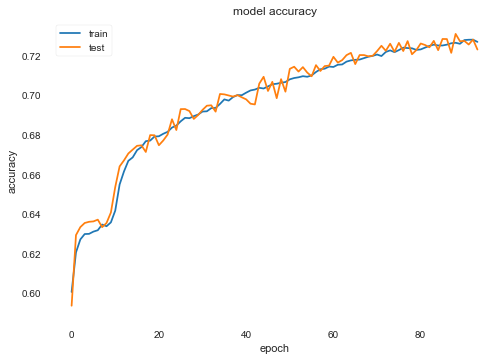

In [37]:
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

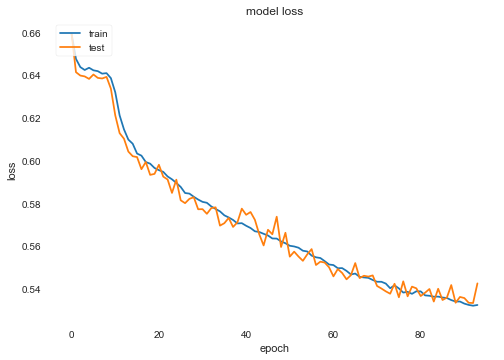

In [38]:
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

I'll use a baseline Random Forest Classifier to compare with the paper's NN

In [39]:
from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests - my simple model to compare with
rf = RandomForestClassifier(max_depth=10, n_estimators=30)
rf.fit(x_train, y_train)

y_pred_rf = rf.predict_proba(x_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

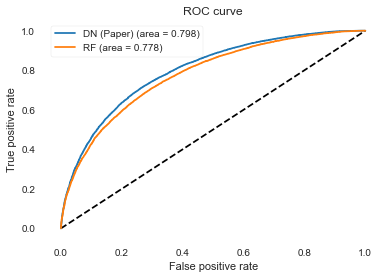

In [40]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='DN (Paper) (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Suggestions for Improvement

* Use another optimizer (like ADAM)
* Use another activation (like ReLu)
* Add dropouts after every dense layer
* Use some kind of ensemble AutoML model in H2O

#### NN #2: Playing around with different parameters

In [46]:
# train/test split (should match above)
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(normalized_X, Y, test_size=0.10, random_state=1776)

In [50]:
from time import time
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
es = EarlyStopping(min_delta=0.001,patience=10)

In [51]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import add, Input
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, TimeDistributed, Bidirectional, Lambda
from tensorflow.keras.layers import SimpleRNN as RNN

model2 = Sequential()
model2.add(Dense(100, input_dim=28, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(50, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(50, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(50, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))
# Compile model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

We've done a few things differently in this model, namely used a different activation function, a different optimizer, lowered the neurons in each hidden layer, and added a dropout after every additional hidden layer. Let's see how the model performs.

In [52]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 100)               2900      
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 50)               

In [53]:
# fit model
history2 = model2.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=300, batch_size=500,callbacks=[es])

Epoch 1/300
450/450 [==============================] - 1s 3ms/step - loss: 0.6627 - accuracy: 0.5930 - val_loss: 0.6277 - val_accuracy: 0.6462
Epoch 2/300
450/450 [==============================] - 1s 3ms/step - loss: 0.6306 - accuracy: 0.6427 - val_loss: 0.6069 - val_accuracy: 0.6684
Epoch 3/300
450/450 [==============================] - 1s 2ms/step - loss: 0.6140 - accuracy: 0.6632 - val_loss: 0.5947 - val_accuracy: 0.6787
Epoch 4/300
450/450 [==============================] - 1s 2ms/step - loss: 0.6038 - accuracy: 0.6724 - val_loss: 0.5874 - val_accuracy: 0.6847
Epoch 5/300
450/450 [==============================] - 1s 2ms/step - loss: 0.5979 - accuracy: 0.6770 - val_loss: 0.5835 - val_accuracy: 0.6851
Epoch 6/300
450/450 [==============================] - 1s 2ms/step - loss: 0.5942 - accuracy: 0.6804 - val_loss: 0.5788 - val_accuracy: 0.6883
Epoch 7/300
450/450 [==============================] - 1s 2ms/step - loss: 0.5897 - accuracy: 0.6843 - val_loss: 0.5793 - val_accuracy: 0.6884

In [54]:
from sklearn.metrics import roc_curve

y_pred_keras = model2.predict(x_test).ravel()
fpr_keras2, tpr_keras2, thresholds_keras2 = roc_curve(y_test, y_pred_keras)

In [55]:
# auc metric for model 2
from sklearn.metrics import auc
auc_keras2 = auc(fpr_keras2, tpr_keras2)
auc_keras2

0.8028664516853572

#### Seeing a negligible improvement in AUC by using different hyperparameters

In [58]:
# Accuracy
scores_rnn = model2.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', scores_rnn[1])

Test accuracy: 0.7256399989128113


#### Comparisons Between NN Models

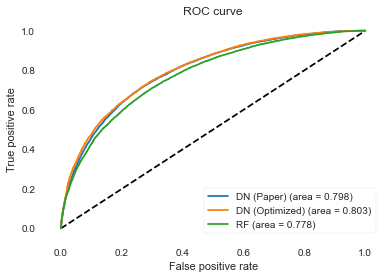

In [59]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='DN (Paper) (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_keras2, tpr_keras2, label='DN (Optimized) (area = {:.3f})'.format(auc_keras2))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

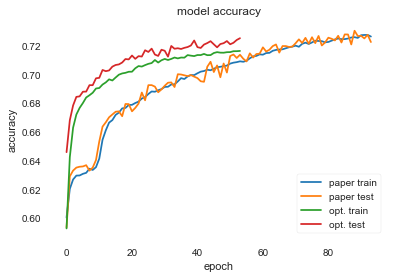

In [60]:
# summarized history for accuracy - both models
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['paper train', 'paper test','opt. train','opt. test'], loc='lower right')
plt.show()

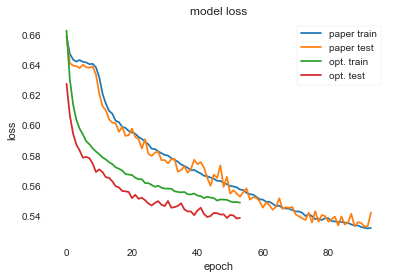

In [61]:
# summarized history for loss - both models
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['paper train', 'paper test','opt. train','opt. test'], loc='upper right')
plt.show()

#### NN #3: Let's see what h2o can do for us

In [62]:
import h2o
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [63]:
h2o.init()           
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 13.0.2+8, mixed mode, sharing)
  Starting server from C:\Users\Mike\anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Mike\AppData\Local\Temp\tmpdc70s6lq
  JVM stdout: C:\Users\Mike\AppData\Local\Temp\tmpdc70s6lq\h2o_Mike_started_from_python.out
  JVM stderr: C:\Users\Mike\AppData\Local\Temp\tmpdc70s6lq\h2o_Mike_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.6
H2O_cluster_version_age:,"21 days, 13 hours and 9 minutes"
H2O_cluster_name:,H2O_from_python_Mike_gip6tu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.990 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


In [64]:
hf = h2o.H2OFrame(higgs)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [65]:
# change label to a factor so h2o recognizes it as a classification problem
hf['label'] = hf['label'].asfactor()

In [66]:
train, valid = hf.split_frame([0.9])
higgs_X = hf.col_names[1:]
higgs_y = hf.col_names[0]

In [67]:
# check out our training set
train.describe()

Rows:225135
Cols:29




,label,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b_tag,jet_2_pt,jet_2_eta,jet_2_phi,jet_2_b_tag,jet_3_pt,jet_3_eta,jet_3_phi,jet_3_b-tag,jet_4_pt,jet_4_eta,jet_4_phi,jet_4_b_tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
type,enum,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real
mins,,0.27469664812088007,-2.434976100921631,-1.7425082921981812,0.0008573559462092817,-1.7439435720443723,0.13997583091259003,-2.9697251319885254,-1.7412374019622805,0.0,0.18898114562034607,-2.913089513778687,-1.7423716783523555,0.0,0.2636076211929321,-2.7296628952026367,-1.7420687675476072,0.0,0.36535415053367615,-2.4972648620605473,-1.742690801620483,0.0,0.10967338830232622,0.2453176081180573,0.13301192224025726,0.15747258067131042,0.04812500998377799,0.30334970355033875,0.35093879699707037
mean,,0.9925129682363737,0.0002530339009423724,-0.0019501659942481129,0.9974959083840549,-0.003794542126559348,0.9890885310646202,-0.0036678367647568285,0.0007024698098383213,0.9996816313300907,0.9914410349400173,0.0013668186361482208,0.0007208418890115992,1.001220382032195,0.9928296035972042,0.0018369812740644054,-0.0026078135893326205,1.003002241153578,0.9857519199849922,-0.0012456657531120122,-2.6017171431840557e-05,0.9959661044294399,1.0344689657458561,1.0243475510226225,1.0505684855221127,1.0108241161266631,0.9723734666676788,1.033213591259379,0.9599400895268592
maxs,,7.543268680572509,2.433893918991089,1.7432359457015991,8.774063110351562,1.7432125806808474,7.076932430267333,2.9696741104125977,1.7414537668228147,2.1730761528015137,11.64708137512207,2.9132099151611333,1.7431747913360591,2.2148721218109126,8.509907722473145,2.730008840560912,1.7428839206695554,2.548224449157715,11.295308113098145,2.498008966445923,1.743372321128845,3.1019613742828365,18.4288272857666,10.038272857666016,5.646420478820801,10.468321800231934,11.994176864624022,7.318191051483155,6.015646934509276
sigma,,0.5654079020383018,1.0066464665552233,1.0058917802106846,0.598699696752793,1.00646494701421,0.4744614346923096,1.0087371870173478,1.0074991451128354,1.027937268693042,0.49930677761235653,1.0065290702519825,1.0074580175818573,1.0488764449892867,0.4866307596259691,1.0095780323538817,1.0044411242024682,1.1950895432405635,0.5042168494047963,1.0087524606013312,1.0067735467436778,1.398153549368655,0.6634730162485394,0.37666121430117294,0.164583739280542,0.3985836871200667,0.5222512770801707,0.36458292571991174,0.31350119408193566
zeros,,0,0,0,0,0,0,0,0,110470,0,0,0,112809,0,0,0,128086,0,0,0,146173,0,0,0,0,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0.739356756210327,-0.1782904267311096,0.8299342393875122,0.5045390725135802,-0.13021674752235413,0.961051344871521,-0.3555179834365845,-1.7173993587493894,2.1730761528015137,0.6209560632705688,-0.4817410409450531,-1.199193239212036,0.0,0.9826014041900634,0.08118502795696257,-0.29032364487648005,0.0,1.0646629333496092,0.7740649580955506,0.3988203406333923,3.1019613742828365,0.9445360302925108,1.0262606143951416,0.9821967482566832,0.5421146750450134,1.250978946685791,0.8300446271896361,0.761307954788208
1,1,1.3840976953506468,0.11682209372520444,-1.1798789501190183,0.7629125714302065,-0.07978226989507675,1.0198631286621092,0.8773182630538942,1.2768871784210205,2.1730761528015137,0.33125209808349604,1.4095234870910645,-1.4743888378143308,0.0,1.282738208770752,0.7374743819236755,-0.22541961073875424,0.0,1.5597530603408811,0.8465205430984498,0.5048085451126099,3.1019613742828365,0.9593246579170226,0.8073760271072387,1.1918135881423952,1.2212103605270384,0.8611412644386292,0.9293408989906312,0.8383023738861084
2,1,1.3835487365722654,0.8891792893409729,0.6185320615768433,1.0815470218658447,0.344605565071106,0.9563793540000916,0.8545429706573486,-1.1292070150375366,2.1730761528015137,0.5456657409667969,-0.30786517262458807,-0.6232798099517823,2.2148721218109126,0.3

In [68]:
higgs_model_v1 = H2ODeepLearningEstimator(model_id = 'higgs_v1', epochs = 10, variable_importances = False)
higgs_model_v1.train(higgs_X, higgs_y, training_frame = train, validation_frame = valid)
print(higgs_model_v1)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  higgs_v1


Status of Neuron Layers: predicting label, 2-class classification, bernoulli distribution, CrossEntropy loss, 46,402 weights/biases, 556.3 KB, 2,300,482 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,28,Input,0.00000,,,,,,,,,
1,,2,200,Rectifier,0.00000,0.00000,0.00000,0.00522,0.00197,0.00000,-0.03851,0.33287,-0.44348,0.26149
2,,3,200,Rectifier,0.00000,0.00000,0.00000,0.02633,0.04702,0.00000,-0.06508,0.16077,0.57494,0.37366
3,,4,2,Softmax,,0.00000,0.00000,0.00211,0.00152,0.00000,0.00278,0.36209,0.03705,0.15765




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.16054170963076106
RMSE: 0.4006765648634333
LogLoss: 0.48631867814814633
Mean Per-Class Error: 0.2411672376980306
AUC: 0.8449702124032353
AUCPR: 0.8510383804113022
Gini: 0.6899404248064707

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40168887331503084: 


,,0,1,Error,Rate
0,0,3153.00000,1679.00000,0.3475,(1679.0/4832.0)
1,1,752.00000,4434.00000,0.145,(752.0/5186.0)
2,Total,3905.00000,6113.00000,0.2427,(2431.0/10018.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.40169,0.78485,238.00000
1,max f2,0.19241,0.86845,322.00000
2,max f0point5,0.60229,0.78537,159.00000
3,max accuracy,0.42573,0.76063,228.00000
4,max precision,0.99766,1.00000,0.00000
5,max recall,0.00323,1.00000,398.00000
6,max specificity,0.99766,1.00000,0.00000
7,max absolute_mcc,0.41715,0.52425,232.00000
8,max min_per_class_accuracy,0.50805,0.75517,196.00000
9,max mean_per_class_accuracy,0.47905,0.75883,207.00000



Gains/Lift Table: Avg response rate: 51.77 %, avg score: 51.45 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.01008,0.98717,1.91261,1.91261,0.99010,0.99173,0.99010,0.99173,0.01928,0.01928,91.26132,91.26132,0.01908
1,2,0.02006,0.98010,1.85447,1.88369,0.96000,0.98350,0.97512,0.98764,0.01851,0.03779,85.44697,88.36861,0.03676
2,3,0.03005,0.97424,1.91242,1.89323,0.99000,0.97744,0.98007,0.98425,0.01909,0.05688,91.24219,89.32329,0.05564
3,4,0.04003,0.96823,1.89310,1.89320,0.98000,0.97086,0.98005,0.98091,0.01890,0.07578,89.31045,89.32009,0.07413
4,5,0.05001,0.96230,1.83515,1.88161,0.95000,0.96512,0.97405,0.97776,0.01832,0.09410,83.51523,88.16143,0.09141
5,6,0.10002,0.92642,1.79679,1.83920,0.93014,0.94420,0.95210,0.96098,0.08986,0.18396,79.67875,83.92009,0.17402
6,7,0.15003,0.88490,1.73895,1.80578,0.90020,0.90621,0.93480,0.94272,0.08696,0.27092,73.89509,80.57842,0.25064
7,8,0.20004,0.84005,1.68111,1.77462,0.87026,0.86290,0.91866,0.92277,0.08407,0.35499,68.11144,77.46168,0.32126
8,9,0.30006,0.73452,1.50568,1.68497,0.77944,0.78781,0.87226,0.87778,0.15060,0.50559,50.56770,68.49702,0.42612
9,10,0.39998,0.62318,1.35473,1.60247,0.70130,0.68028,0.82955,0.82844,0.13536,0.64096,35.47263,60.24710,0.49961




ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.1764140895682205
RMSE: 0.4200167729605813
LogLoss: 0.5281110247151782
Mean Per-Class Error: 0.26432014965542705
AUC: 0.8140388026502442
AUCPR: 0.8223018522776046
Gini: 0.6280776053004884

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35219690823503924: 


,,0,1,Error,Rate
0,0,6562.00000,5284.00000,0.4461,(5284.0/11846.0)
1,1,1700.00000,11319.00000,0.1306,(1700.0/13019.0)
2,Total,8262.00000,16603.00000,0.2809,(6984.0/24865.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.35220,0.76423,258.00000
1,max f2,0.12991,0.86326,346.00000
2,max f0point5,0.62082,0.75781,152.00000
3,max accuracy,0.51256,0.73509,195.00000
4,max precision,0.99260,0.97403,2.00000
5,max recall,0.00077,1.00000,399.00000
6,max specificity,0.99778,0.99992,0.00000
7,max absolute_mcc,0.53183,0.47093,187.00000
8,max min_per_class_accuracy,0.50751,0.73434,197.00000
9,max mean_per_class_accuracy,0.52695,0.73568,189.00000



Gains/Lift Table: Avg response rate: 52.36 %, avg score: 51.72 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.01001,0.98843,1.85621,1.85621,0.97189,0.99284,0.97189,0.99284,0.01859,0.01859,85.62089,85.62089,0.01800
1,2,0.02003,0.98172,1.81786,1.83703,0.95181,0.98495,0.96185,0.98889,0.01820,0.03679,81.78575,83.70332,0.03519
2,3,0.03000,0.97499,1.82519,1.83310,0.95565,0.97842,0.95979,0.98541,0.01820,0.05500,82.51876,83.30952,0.05246
3,4,0.04002,0.96878,1.82553,1.83120,0.95582,0.97195,0.95879,0.98204,0.01828,0.07328,82.55278,83.12015,0.06982
4,5,0.05003,0.96244,1.80252,1.82546,0.94378,0.96578,0.95579,0.97879,0.01805,0.09133,80.25169,82.54600,0.08669
5,6,0.10002,0.92502,1.72091,1.77321,0.90105,0.94439,0.92843,0.96159,0.08603,0.17736,72.09083,77.32052,0.16233
6,7,0.15001,0.88442,1.66252,1.73632,0.87047,0.90564,0.90912,0.94295,0.08311,0.26047,66.25203,73.63201,0.23185
7,8,0.20000,0.83648,1.60413,1.70328,0.83990,0.86124,0.89182,0.92252,0.08019,0.34066,60.41324,70.32798,0.29524
8,9,0.30002,0.72897,1.43838,1.61497,0.75312,0.78389,0.84558,0.87631,0.14387,0.48452,43.83773,61.49672,0.38727
9,10,0.40000,0.62014,1.30067,1.53641,0.68101,0.67349,0.80444,0.82561,0.13004,0.61456,30.06686,53.64083,0.45037




Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,...,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-07-22 08:55:05,0.000 sec,None,0.00000,0,0.00000,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,,2020-07-22 08:55:08,3.412 sec,44072 obs/sec,0.44535,1,100264.00000,0.44191,0.57294,0.21787,...,0.77890,1.81698,0.32132,0.44365,0.57638,0.21093,0.76862,0.77181,1.80252,0.32310
2,,2020-07-22 08:55:14,9.194 sec,63849 obs/sec,2.22147,5,500130.00000,0.42380,0.53457,0.28067,...,0.81576,1.89349,0.29068,0.42910,0.54549,0.26187,0.79846,0.80588,1.86388,0.29765
3,,2020-07-22 08:55:19,14.338 sec,70623 obs/sec,4.00147,9,900870.00000,0.41453,0.51467,0.31180,...,0.82928,1.87436,0.26872,0.42279,0.53192,0.28341,0.80753,0.81649,1.87922,0.28164
4,,2020-07-22 08:55:25,20.317 sec,75460 obs/sec,6.22224,14,1400845.00000,0.40932,0.50449,0.32898,...,0.83573,1.91261,0.26762,0.42158,0.53006,0.28750,0.81048,0.81914,1.84854,0.27537
5,,2020-07-22 08:55:30,26.028 sec,78871 obs/sec,8.44261,19,1900728.00000,0.40433,0.49419,0.34525,...,0.84595,1.91261,0.25524,0.42081,0.52830,0.29009,0.81185,0.82141,1.84854,0.28132
6,,2020-07-22 08:55:35,30.585 sec,80769 obs/sec,10.21823,23,2300482.00000,0.40068,0.48632,0.35703,...,0.85104,1.91261,0.24266,0.42002,0.52811,0.29277,0.81404,0.82230,1.85621,0.28088


In [69]:
higgs_model_v1.auc(train=True, valid=True, xval=False)

{'train': 0.8449702124032353, 'valid': 0.8140388026502442}

Highest AUC for any model, although still a 3% difference in training versus validation AUC, meaning it might not necessarily be generalizing the best. Let's include some dropouts and see what it does.

In [70]:
higgs_model_v2 = H2ODeepLearningEstimator(model_id = 'higgs_v2', epochs = 10, variable_importances = True, activation = 'rectifier_with_dropout',  loss="CrossEntropy", balance_classes=False)
higgs_model_v2.train(higgs_X, higgs_y, training_frame = train, validation_frame = valid)
print(higgs_model_v2)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  higgs_v2


Status of Neuron Layers: predicting label, 2-class classification, bernoulli distribution, CrossEntropy loss, 46,402 weights/biases, 556.6 KB, 2,298,714 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,28,Input,0.00000,,,,,,,,,
1,,2,200,RectifierDropout,50.00000,0.00000,0.00000,0.00361,0.00173,0.00000,-0.02107,0.26562,-0.38897,0.24681
2,,3,200,RectifierDropout,50.00000,0.00000,0.00000,0.01943,0.02822,0.00000,-0.07227,0.17208,0.20436,0.30320
3,,4,2,Softmax,,0.00000,0.00000,0.00344,0.00325,0.00000,-0.03254,0.32444,0.38496,0.05431




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1860146026507463
RMSE: 0.43129410226752035
LogLoss: 0.5492437240906001
Mean Per-Class Error: 0.28118217872411266
AUC: 0.7925335301410567
AUCPR: 0.8109072454135412
Gini: 0.5850670602821133

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41373443305208185: 


,,0,1,Error,Rate
0,0,2118.00000,2523.00000,0.5436,(2523.0/4641.0)
1,1,577.00000,4750.00000,0.1083,(577.0/5327.0)
2,Total,2695.00000,7273.00000,0.311,(3100.0/9968.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.41373,0.75397,259.00000
1,max f2,0.20713,0.86456,339.00000
2,max f0point5,0.55654,0.74334,188.00000
3,max accuracy,0.52531,0.71980,205.00000
4,max precision,0.99524,1.00000,0.00000
5,max recall,0.01653,1.00000,397.00000
6,max specificity,0.99524,1.00000,0.00000
7,max absolute_mcc,0.55324,0.43671,190.00000
8,max min_per_class_accuracy,0.53955,0.71407,197.00000
9,max mean_per_class_accuracy,0.55324,0.71882,190.00000



Gains/Lift Table: Avg response rate: 53.44 %, avg score: 55.09 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.01003,0.95422,1.79637,1.79637,0.96000,0.96487,0.96000,0.96487,0.01802,0.01802,79.63732,79.63732,0.01716
1,2,0.02006,0.94457,1.77766,1.78702,0.95000,0.94907,0.95500,0.95697,0.01783,0.03586,77.76610,78.70171,0.03392
2,3,0.03010,0.93550,1.79637,1.79014,0.96000,0.93990,0.95667,0.95128,0.01802,0.05388,79.63732,79.01358,0.05108
3,4,0.04003,0.92586,1.81452,1.79619,0.96970,0.93013,0.95990,0.94603,0.01802,0.07190,81.45184,79.61856,0.06845
4,5,0.05006,0.91685,1.74024,1.78497,0.93000,0.92116,0.95391,0.94105,0.01746,0.08936,74.02365,78.49734,0.08440
5,6,0.10002,0.87955,1.67208,1.72858,0.89357,0.89815,0.92377,0.91962,0.08354,0.17289,67.20760,72.85813,0.15652
6,7,0.15008,0.83402,1.62373,1.69361,0.86774,0.85715,0.90508,0.89878,0.08128,0.25418,62.37258,69.36061,0.22358
7,8,0.20004,0.78118,1.52553,1.65163,0.81526,0.80856,0.88265,0.87625,0.07622,0.33039,52.55345,65.16303,0.27997
8,9,0.30006,0.67672,1.37949,1.56092,0.73721,0.72532,0.83417,0.82594,0.13798,0.46837,37.94867,56.09158,0.36150
9,10,0.39998,0.59950,1.23621,1.47980,0.66064,0.63740,0.79082,0.77884,0.12352,0.59189,23.62090,47.98002,0.41219




ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.18261272969439635
RMSE: 0.42733210702496527
LogLoss: 0.5419327410607263
Mean Per-Class Error: 0.27097281175967214
AUC: 0.8046526358306151
AUCPR: 0.8133290759798111
Gini: 0.6093052716612302

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45036257144083713: 


,,0,1,Error,Rate
0,0,6266.00000,5580.00000,0.471,(5580.0/11846.0)
1,1,1689.00000,11330.00000,0.1297,(1689.0/13019.0)
2,Total,7955.00000,16910.00000,0.2923,(7269.0/24865.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.45036,0.75713,237.00000
1,max f2,0.24290,0.86052,324.00000
2,max f0point5,0.59112,0.74863,166.00000
3,max accuracy,0.54117,0.72930,192.00000
4,max precision,0.97741,0.97619,2.00000
5,max recall,0.02254,1.00000,396.00000
6,max specificity,0.99022,0.99992,0.00000
7,max absolute_mcc,0.54117,0.45780,192.00000
8,max min_per_class_accuracy,0.54349,0.72868,191.00000
9,max mean_per_class_accuracy,0.54117,0.72903,192.00000



Gains/Lift Table: Avg response rate: 52.36 %, avg score: 55.37 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.01001,0.95656,1.80252,1.80252,0.94378,0.96711,0.94378,0.96711,0.01805,0.01805,80.25169,80.25169,0.01687
1,2,0.02003,0.94490,1.86388,1.83320,0.97590,0.95055,0.95984,0.95883,0.01867,0.03672,86.38792,83.31981,0.03503
2,3,0.03000,0.93603,1.82519,1.83054,0.95565,0.94053,0.95845,0.95275,0.01820,0.05492,82.51876,83.05351,0.05230
3,4,0.04002,0.92700,1.77951,1.81776,0.93173,0.93129,0.95176,0.94738,0.01782,0.07274,77.95061,81.77650,0.06869
4,5,0.05003,0.91893,1.78718,1.81164,0.93574,0.92260,0.94855,0.94242,0.01790,0.09064,78.71764,81.16423,0.08523
5,6,0.10002,0.88129,1.72859,1.77013,0.90507,0.90012,0.92682,0.92128,0.08641,0.17705,72.85909,77.01333,0.16169
6,7,0.15001,0.83863,1.66713,1.73581,0.87289,0.86071,0.90885,0.90109,0.08334,0.26039,66.71299,73.58081,0.23169
7,8,0.20000,0.78829,1.54113,1.68715,0.80692,0.81425,0.88337,0.87939,0.07704,0.33743,54.11348,68.71496,0.28847
8,9,0.30002,0.68661,1.40766,1.59397,0.73703,0.73626,0.83458,0.83167,0.14079,0.47822,40.76592,59.39736,0.37405
9,10,0.40000,0.60356,1.27455,1.51413,0.66734,0.64256,0.79278,0.78440,0.12743,0.60565,27.45477,51.41332,0.43167




Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,...,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-07-22 08:57:05,0.000 sec,None,0.00000,0,0.00000,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,,2020-07-22 08:57:06,1.778 sec,72338 obs/sec,0.44341,1,99827.00000,0.46492,0.62099,0.13127,...,0.72618,1.79637,0.37139,0.46115,0.61289,0.14746,0.72496,0.72726,1.77951,0.36871
2,,2020-07-22 08:57:11,6.781 sec,96650 obs/sec,2.66509,6,600006.00000,0.44153,0.57082,0.21650,...,0.79003,1.79637,0.33206,0.43571,0.55899,0.23895,0.78278,0.79339,1.81019,0.31993
3,,2020-07-22 08:57:16,11.872 sec,107763 obs/sec,5.32511,12,1198869.00000,0.43498,0.55658,0.23957,...,0.80147,1.79637,0.31310,0.42972,0.54616,0.25972,0.79656,0.80607,1.85621,0.29278
4,,2020-07-22 08:57:22,17.551 sec,114206 obs/sec,8.43354,19,1898685.00000,0.43192,0.55064,0.25022,...,0.80770,1.81509,0.30407,0.42825,0.54335,0.26478,0.80130,0.81093,1.81019,0.29318
5,,2020-07-22 08:57:25,20.747 sec,117000 obs/sec,10.21038,23,2298714.00000,0.43129,0.54924,0.25240,...,0.81091,1.79637,0.31100,0.42733,0.54193,0.26792,0.80465,0.81333,1.80252,0.29234



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,m_bb,1.00000,1.00000,0.15155
1,m_wbb,0.69646,0.69646,0.10555
2,m_jjj,0.60164,0.60164,0.09118
3,m_wwbb,0.58639,0.58639,0.08887
4,m_jj,0.41720,0.41720,0.06323
5,m_jlv,0.37969,0.37969,0.05754
6,jet_1_pt,0.35598,0.35598,0.05395
7,lepton_pT,0.30118,0.30118,0.04564
8,missing_energy_magnitude,0.21131,0.21131,0.03202
9,jet_4_b_tag,0.20728,0.20728,0.03141



See the whole table with table.as_data_frame()



In [71]:
higgs_model_v2.auc(train=True, valid=True, xval=False)

{'train': 0.7925335301410567, 'valid': 0.8046526358306151}

Not our best model, however we are getting comparable AUC for the validation set, and it seems to be a better model for generalizing.

### Model Comparison

In [105]:
H2O_optimized = higgs_model_v2.auc(valid=True)

In [106]:
H2O_defaults = higgs_model_v1.auc(valid=True)

In [107]:
NN_paper_optimized = auc_keras2

In [108]:
NN_paper = auc_keras

In [109]:
Random_forest = auc_rf

In [110]:
from tabulate import tabulate

results = [("NN_paper",NN_paper),("Random_forest",Random_forest),("NN_paper_optimized",NN_paper_optimized),("H2O_defaults",H2O_defaults),("H2O_optimized",H2O_optimized)]
headers = ["Model","AUC"]

print(tabulate(results, headers = headers,))

Model                    AUC
------------------  --------
NN_paper            0.798382
Random_forest       0.77802
NN_paper_optimized  0.802866
H2O_defaults        0.814039
H2O_optimized       0.804653
